In [1]:
import torch
print("cuDNN available:", torch.backends.cudnn.is_available())
print("cuDNN version:", torch.backends.cudnn.version())
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())


cuDNN available: True
cuDNN version: 8902
2.3.0+cu121
12.1
8902


In [2]:
import os
import re
import gc
import sys
import time
import random
import csv
import shutil
import pathlib
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numba import jit, cuda
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import Adadelta, SGD
from torchvision import models, transforms
from torch_optimizer import Lamb
import timm

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics import Metric, F1Score
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from tqdm.notebook import tqdm

import json

In [3]:

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

# Path to the images and CSV file
img_dir = './data/images'
train_file = './data/train_binarized.csv'
test_file = './data/test.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file, usecols=['ImageID'])
train_df





Using cuda for training


,ImageID,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19
0,0.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.jpg,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,4.jpg,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
29996,29996.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29997,29997.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29998,29998.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
import os
class ImageDataset(Dataset):
    def __init__(self,df, img_dir, transform=None):
        self.df=df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx,0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        labels = self.df.iloc[idx, 1:19].values.astype('float')
        
        if self.transform:
            image = self.transform(image)
        
        return img_name,image, labels

# Transformations for the images

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomVerticalFlip(p=0.5),  # 50% chance of flipping vertically
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change the brightness, contrast, saturation and hue
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 30 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random affine transformations with translation and scaling
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective transformation with a 50% chance
    transforms.RandomGrayscale(p=0.1),  # Randomly convert image to grayscale with a 10% chance
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor with mean and std for pre-trained models
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization parameters for pre-trained models
])

In [5]:
from sklearn.model_selection import train_test_split

train_set , val_set = train_test_split(train_df,test_size = 0.3)


train_dataset = ImageDataset(train_set,img_dir=img_dir, transform=transform)
val_dataset = ImageDataset(val_set,img_dir=img_dir, transform=transform)
test_dataset = ImageDataset(test_df,img_dir=img_dir, transform=test_transform)


train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = 64,
                                               shuffle = True,num_workers=5)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = 64,
                                               shuffle = False,num_workers=5)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = 1,
                                               shuffle = False,num_workers=5)



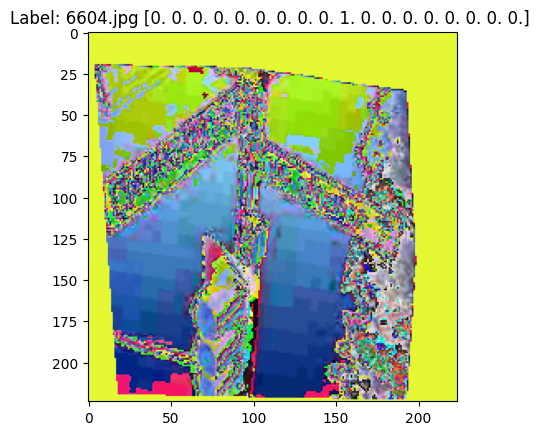

In [6]:
import torchvision.transforms.functional as F

image_name,image, label = train_dataset[0]  

image = F.to_pil_image(image)
print()
# Display the image
plt.imshow(image)
plt.title(f'Label: {image_name} {label} ')
plt.show()

In [7]:

timm.list_models("resnet*")

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50c',
 'resnet50d',
 'resnet50s',
 'resnet50t',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet152',
 'resnet152c',
 'resnet152d',
 'resnet152s',
 'resnet200',
 'resnet200d',
 'resnetaa34d',
 'resnetaa50',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur18',
 'resnetblur50',
 'resnetblur50d',
 'resnetblur101d',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2_50t',
 'resnetv2_50x1_bit',
 'resnetv2_50x3_bit',
 'resnetv2_101',
 'resnetv2_101d',
 'resnetv2_101x1_bit',
 'resnetv2_101x3_bit',
 'resnetv2_152',
 'resnetv2_152d',
 'resnetv2_152x2_bit',
 'resnetv2_152x4_bit']

In [8]:
timm.list_models("resnetv2*")

['resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2_50t',
 'resnetv2_50x1_bit',
 'resnetv2_50x3_bit',
 'resnetv2_101',
 'resnetv2_101d',
 'resnetv2_101x1_bit',
 'resnetv2_101x3_bit',
 'resnetv2_152',
 'resnetv2_152d',
 'resnetv2_152x2_bit',
 'resnetv2_152x4_bit']

In [10]:

# Backbone definition using ResNeXt50_32x4d
backbone = timm.create_model('resnext50_32x4d.a1h_in1k', pretrained=True)
backbone.reset_classifier(0)  

# Custom Multilabel Classification Network
class MLCNNet(nn.Module):
    def __init__(self, backbone, n_classes):
        super(MLCNNet, self).__init__()
        self.model = backbone
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),  
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

model = MLCNNet(backbone, 18)

In [11]:
import torch.nn.functional as F
from torchmetrics.classification import MultilabelF1Score

class LitMLCNet(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.f1_score = MultilabelF1Score(num_labels=18, average='macro')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        img_name, x, y = batch
        logits = self.model(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        f1 = self.f1_score(logits.sigmoid(), y.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'f1': f1}

    def validation_step(self, batch, batch_idx):
        img_name, x, y = batch
        logits = self.model(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        f1 = self.f1_score(logits.sigmoid(), y.int())
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_f1', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'val_loss': loss, 'val_f1': f1}

    def configure_optimizers(self):
        optimizer = Lamb(self.parameters(), lr=0.001)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_f1"}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        img_name, x, _ = batch  
        preds = self.forward(x)
        return preds, img_name


In [19]:
pl_Model = LitMLCNet(model)

torch.set_float32_matmul_precision('high')

weights_path = './models/FINAL_RESNEXT.pth'
pl_Model.load_state_dict(torch.load(weights_path),strict=False)

# trainer = pl.Trainer()

#Uncomment if training model 

trainer = pl.Trainer(
    default_root_dir='./',
    max_epochs=20,  # Increased epochs
    log_every_n_steps=10,
    accelerator='gpu',
    devices=1,
    logger=True
)

trainer.fit(pl_Model,
            train_dataloader,
            val_dataloader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | model    | MLCNNet           | 24.2 M
1 | f1_score | MultilabelF1Score | 0     
-----------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params
96.666    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [21]:
model_path = './models/FINAL_RESNEXT_60e.pth'
torch.save(pl_Model.state_dict(), model_path)


In [22]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 34632), started 16:29:25 ago. (Use '!kill 34632' to kill it.)

In [15]:
preds_labels = trainer.predict(pl_Model, dataloaders=test_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
import csv
import numpy as np

# Define the threshold
threshold = 0.5

# List of possible labels
possible_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]

# Convert predictions to label format
def get_labels_from_logits(logits, threshold=threshold):
    return [str(possible_labels[i]) for i in range(len(logits)) if logits[i] >= threshold]

# Prepare the data for CSV
csv_data = []
for preds, img_name in preds_labels:
    preds = preds.sigmoid().cpu().numpy()
    img_name = img_name[0]  # Assuming img_name is a single-element list
    labels_str = " ".join(get_labels_from_logits(preds[0]))
    csv_data.append([img_name, labels_str])

# Write to CSV
csv_file = './predictions/510369965-490424191-490299418-ResNext-Predictions.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ImageID', 'Labels'])
    writer.writerows(csv_data)

print(f"Predictions saved to {csv_file}")


Predictions saved to ./predictions/510369965-490424191-490299418-ResNext-Predictions.csv


In [17]:
predictions = []
for preds, img_names in preds_labels:
        for pred, img_name in zip(preds, img_names):
          predictions.append(torch.sigmoid(pred))

predictions = [tensor.tolist() for tensor in predictions]

with open('./processed-data/rawPredictions-resnet.json', 'w', encoding='utf-8') as f:
    json.dump(predictions, f, ensure_ascii=False, indent=4)